In [34]:
import torch
from Define_Model.ResNet import ThinResNet
import numpy as np
import kaldi_io
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
plt.rc('font', family='Times New Roman')


In [35]:
model = ThinResNet(resnet_size=34, block_type='None', channels=[16, 32, 64, 128],
                 input_len=300, inst_norm=False, input_dim=161, sr=16000, input_norm='Mean',
                 kernel_size=5, stride=2, padding=2, dropout_p=0.0, exp=False, filter_fix=False,
                 feat_dim=64, num_classes=1211, embedding_size=128, fast=False, time_dim=1, avg_size=4,
                 alpha=0, encoder_type='STAP', )

In [36]:
ckp = torch.load('/home/yangwenhao/local/project/SpeakerVerification-pytorch/Data/checkpoint/ThinResNet34/vox1/spect_egs_mean/soft/STAP_em128_alpha0_wde4/checkpoint_50.pth')
model.load_state_dict(ckp['state_dict'][0])


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [37]:
# print(list(ckp['state_dict'][0].keys()))
for name, m in model.named_modules():
    print(name)


inst_layer
conv1
bn1
relu
layer1
layer1.0
layer1.0.conv1
layer1.0.bn1
layer1.0.relu
layer1.0.conv2
layer1.0.bn2
layer1.1
layer1.1.conv1
layer1.1.bn1
layer1.1.relu
layer1.1.conv2
layer1.1.bn2
layer1.2
layer1.2.conv1
layer1.2.bn1
layer1.2.relu
layer1.2.conv2
layer1.2.bn2
layer2
layer2.0
layer2.0.conv1
layer2.0.bn1
layer2.0.relu
layer2.0.conv2
layer2.0.bn2
layer2.0.downsample
layer2.0.downsample.0
layer2.0.downsample.1
layer2.1
layer2.1.conv1
layer2.1.bn1
layer2.1.relu
layer2.1.conv2
layer2.1.bn2
layer2.2
layer2.2.conv1
layer2.2.bn1
layer2.2.relu
layer2.2.conv2
layer2.2.bn2
layer2.3
layer2.3.conv1
layer2.3.bn1
layer2.3.relu
layer2.3.conv2
layer2.3.bn2
layer3
layer3.0
layer3.0.conv1
layer3.0.bn1
layer3.0.relu
layer3.0.conv2
layer3.0.bn2
layer3.0.downsample
layer3.0.downsample.0
layer3.0.downsample.1
layer3.1
layer3.1.conv1
layer3.1.bn1
layer3.1.relu
layer3.1.conv2
layer3.1.bn2
layer3.2
layer3.2.conv1
layer3.2.bn1
layer3.2.relu
layer3.2.conv2
layer3.2.bn2
layer3.3
layer3.3.conv1
layer3.3.b

In [38]:
module = model.layer4[0].bn2
b = - (module.running_mean * module.weight / torch.sqrt(module.running_var + module.eps)) + module.bias
b.data.shape

torch.Size([128])

In [39]:
out_feature_grads = []
in_feature_grads = []
in_feature = {}
out_feature = {}


def extract_layer_bias(module):
    # extract bias of each layer

    # for batchnorm, the overall "bias" is different
    # from batchnorm bias parameter.
    # Let m -> running mean, s -> running std
    # Let w -> BN weights, b -> BN bias
    # Then, ((x - m)/s)*w + b = x*w/s + (- m*w/s + b)
    # Thus (-m*w/s + b) is the effective bias of batchnorm
#     print(type(m))
    if isinstance(module, torch.nn.BatchNorm2d):
#         print('bn2')
        b = - (module.running_mean * module.weight
                / torch.sqrt(module.running_var + module.eps)) + module.bias
        return b.data
    elif module.bias is None:
        return None
    else:
        return module.bias.data
    
def _extract_layer_grads(module, in_grad, out_grad):
    # function to collect the gradient outputs
    # from each layer
#     print(module._get_name())
#     print('Input_grad shape:', in_grad[0].shape)
#     print('Output_grad shape:', out_grad[0].shape)
    if not module.bias is None:
        in_feature_grads.append(in_grad[0])
        out_feature_grads.append(out_grad[0])
        
def _extract_layer_feat(module, input, output):
    # function to collect the gradient outputs
    # from each layer
#     print(module._get_name())
#     print('Input_grad shape:', in_grad[0].shape)
#     print('Output_grad shape:', out_grad[0].shape)
    
    if not module.bias is None:
        in_feature[module._get_name()] = input[0]
        out_feature[module._get_name()] = output[0]

In [40]:
bias_layers = []
biases = []
for name, m in model.named_modules():
    try:
#         if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear) or isinstance(m, nn.BatchNorm2d):
        if not ('fc' in name or 'classifier' in name) : 
#             print(m)
            b = extract_layer_bias(m)
            if (b is not None): 
                biases.append(b)
                bias_layers.append(name)
                    
#                 biases.append(_extract_layer_bias(m))
#                 print("bias:", _extract_layer_bias(m))
                m.register_backward_hook(_extract_layer_grads)
#                     m.register_forward_hook(_extract_layer_feat)
    except Exception as e:
        continue

# for name, m in model.named_modules():
#     if not ('fc' in name or 'classifier' in name) : 
#         b = self._extract_layer_bias(m)
#         if (b is not None): 
#             biases.append(b)
#             bias_layers.append(name)
        
        
        
print(bias_layers)
print(biases)

['conv1', 'bn1', 'layer1.0.bn1', 'layer1.0.bn2', 'layer1.1.bn1', 'layer1.1.bn2', 'layer1.2.bn1', 'layer1.2.bn2', 'layer2.0.bn1', 'layer2.0.bn2', 'layer2.0.downsample.1', 'layer2.1.bn1', 'layer2.1.bn2', 'layer2.2.bn1', 'layer2.2.bn2', 'layer2.3.bn1', 'layer2.3.bn2', 'layer3.0.bn1', 'layer3.0.bn2', 'layer3.0.downsample.1', 'layer3.1.bn1', 'layer3.1.bn2', 'layer3.2.bn1', 'layer3.2.bn2', 'layer3.3.bn1', 'layer3.3.bn2', 'layer3.4.bn1', 'layer3.4.bn2', 'layer3.5.bn1', 'layer3.5.bn2', 'layer4.0.bn1', 'layer4.0.bn2', 'layer4.0.downsample.1', 'layer4.1.bn1', 'layer4.1.bn2', 'layer4.2.bn1', 'layer4.2.bn2']
[tensor([-2.0485e-06,  1.0789e-06,  4.9520e-07, -5.2394e-07,  1.8125e-06,
         9.2067e-07,  2.1925e-06, -2.1209e-06,  1.1187e-06, -2.3506e-06,
        -2.7145e-06,  2.6436e-06,  2.2178e-06,  1.4701e-06, -8.0869e-07,
        -2.6488e-06]), tensor([ 8.9980e-01,  5.1848e-01,  6.9058e-02, -2.5161e-05,  7.9471e-02,
        -2.5034e-01,  8.4304e-01,  5.5216e-02,  4.7765e-02,  1.0957e-01,
       

In [41]:

x1 = kaldi_io.read_mat('/home/work2020/yangwenhao/project/lstm_speaker_verification/data/vox1/spect/dev_log/Split18/0/dev_log_feat.0.ark:26')
x = torch.tensor(x1).reshape(1,1,-1,161).requires_grad_()
print(x.shape)

torch.Size([1, 1, 468, 161])


In [42]:
model.eval()
logits, feat = model(x)
logits[0].max().backward()
# print(feature_grads[0].shape)

In [64]:
print(len(bias_layers))
print(len(out_feature_grads))

ups = torch.nn.UpsamplingBilinear2d(size=(468, 161))
input_gradient = (x.grad * x).clamp_min(0)
grad = x.grad.clamp_min(0)
full_grad = input_gradient.clone()

L = len(bias_layers)
for i,l in enumerate(bias_layers):
    
    bias = biases[L-i-1]
    if len(bias.shape) == 1:
        bias = bias.reshape(1,-1,1,1)
        
    bias = bias.expand_as(out_feature_grads[i])
    
#     bias_grad = (out_feature_grads[i]*bias).abs().sum(dim=1, keepdim=True)
    bias_grad = (out_feature_grads[i]*bias).clamp_min(0).mean(dim=1, keepdim=True)
#     bias_grad /= bias_grad.max()
    
    full_grad += ups(bias_grad)

37
37


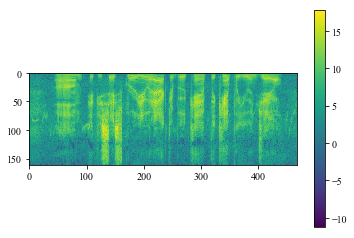

In [65]:
im = plt.imshow(x1.transpose())
plt.colorbar(im)  # 显示颜色标尺
# print(list(in_feature_grads.keys()))
# print(list(in_feature.keys()))


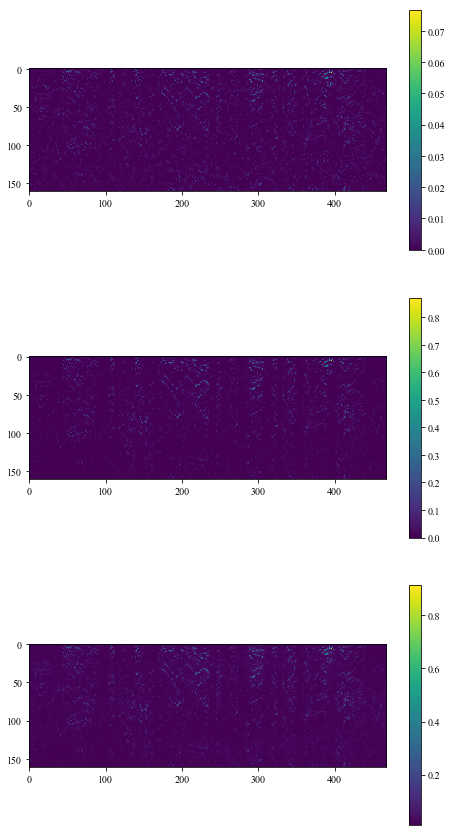

In [69]:
plt.figure(figsize=(8, 15))
# norm = matplotlib.colors.Normalize(vmin=-10., vmax=10.)

ax = plt.subplot(3, 1, 1)
im = ax.imshow(grad.squeeze().detach().numpy().transpose()) #, norm=norm)
plt.colorbar(im)  # 显示颜色标尺

ax = plt.subplot(3, 1, 2)
im = ax.imshow(input_gradient.squeeze().detach().numpy().transpose()) #, norm=norm)
plt.colorbar(im)  # 显示颜色标尺

ax = plt.subplot(3, 1, 3)
im = ax.imshow(full_grad.squeeze().detach().numpy().transpose()) #, norm=norm)
plt.colorbar(im)  # 显示颜色标尺


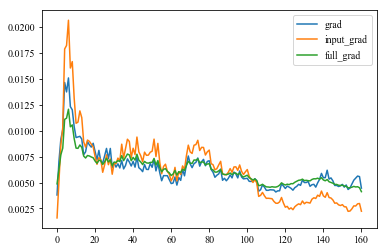

In [71]:
def plot_grad(grad, axis):
    this_grad = grad.squeeze().detach().numpy().transpose().mean(axis=axis)
    this_grad /= this_grad.sum()
    plt.plot(this_grad)


plot_grad(grad, 1)
plot_grad(input_gradient, 1)
plot_grad(full_grad, 1)
plt.legend(['grad', 'input_grad', 'full_grad'])

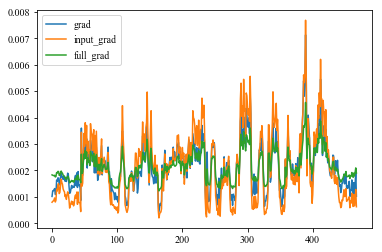

In [72]:
plot_grad(grad, 0)
plot_grad(input_gradient, 0)
plot_grad(full_grad, 0)

plt.legend(['grad', 'input_grad', 'full_grad'])

In [62]:
im = plt.imshow(in_feature_grads['Conv2d'].squeeze().numpy().transpose())
plt.colorbar(im)  # 显示颜色标尺


TypeError: list indices must be integers or slices, not str

In [13]:
bias_gradient = b.reshape(1,-1,1,1).expand_as(in_feature_grads['BatchNorm2d'])*in_feature_grads['BatchNorm2d'].abs()
input_graident = (in_feature_grads['BatchNorm2d'] * in_feature['BatchNorm2d']).abs() # + bias_gradient

bias_gradient = bias_gradient.sum(dim=1, keepdim=True)
bias_gradient /= bias_gradient.max()

input_graident = input_graident.sum(dim=1, keepdim=True)
input_graident /= input_graident.max()



In [14]:
# input_grad* input + bias_gradient
# print(in_feature['BatchNorm2d'])


In [15]:
upsample = torch.nn.UpsamplingBilinear2d(size=(468, 161))
input_graident = upsample(input_graident)
bias_gradient = upsample(bias_gradient)

saliency_map = input_graident + bias_gradient

print(saliency_map.shape)

torch.Size([1, 1, 468, 161])


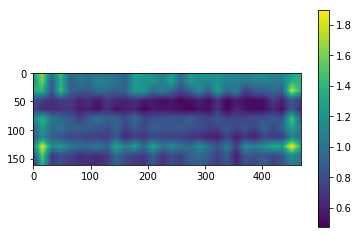

In [16]:
im = plt.imshow(saliency_map.squeeze().detach().numpy().transpose())
plt.colorbar(im)  # 显示颜色标尺


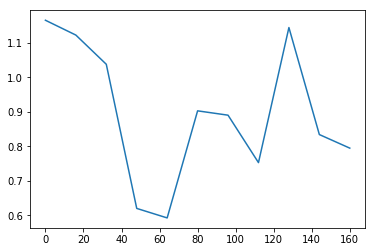

In [17]:
plt.plot(saliency_map.squeeze().detach().numpy().transpose().mean(axis=1))

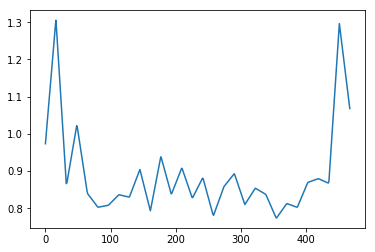

In [18]:
plt.plot(saliency_map.squeeze().detach().numpy().transpose().mean(axis=0))